In [87]:
import pandas as pd
import numpy as np
import matplotlib as plt
import tensorflow as tf
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from importlib import reload

# custom module for capstone 2
import cap2tools as c2t
reload(c2t)

<module 'cap2tools' from 'C:\\Users\\Nils\\Documents\\GitHub\\Springboard-Capstone-2-local-yelp\\cap2tools.py'>

In [2]:
# configure GPU memory usage by tensorflow
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
K.tensorflow_backend.set_session(K.tf.Session(config=config))

In [3]:
# define paths to image directories
train_path = 'downsampled/train'
valid_path = 'downsampled/val'

# create data generators
train_batches, valid_batches = c2t.build_datagens(train_path, valid_path, augment=True)

Found 5480 images belonging to 5 classes.
Found 525 images belonging to 5 classes.


In [4]:
# test various widths for model
widths = [400, 600, 800, 1000, 1200, 1400, 1600]
replicates = 3
n_epochs = 8

histories = dict()
model_paths = dict()

for width in widths:
    condition = 'width_{}'.format(str(width))
    histories[width] = c2t.run_in_replicate(width, condition, train_batches, valid_batches, 
                                            replicates=replicates, n_epochs=n_epochs, new_weights=False, 
                                            trainable=True)
    
    # add key-value pairs to model_paths
    for i in range(1, replicates+1):
        key = condition + ' - ' + str(i)
        value = 'models/vgg16_{}_{}.h5'.format(condition, str(i))
        model_paths[key] = value

2018-09-19 00:47:32 - Started training models/vgg16_width_400_1
2018-09-19 01:07:09 - Started training models/vgg16_width_400_2
2018-09-19 01:26:06 - Started training models/vgg16_width_400_3
2018-09-19 01:45:04 - Started training models/vgg16_width_600_1
2018-09-19 02:04:37 - Started training models/vgg16_width_600_2
2018-09-19 02:24:09 - Started training models/vgg16_width_600_3
2018-09-19 02:43:44 - Started training models/vgg16_width_800_1
2018-09-19 03:03:50 - Started training models/vgg16_width_800_2
2018-09-19 03:23:46 - Started training models/vgg16_width_800_3
2018-09-19 03:43:50 - Started training models/vgg16_width_1000_1
2018-09-19 04:04:29 - Started training models/vgg16_width_1000_2
2018-09-19 04:25:08 - Started training models/vgg16_width_1000_3
2018-09-19 04:46:22 - Started training models/vgg16_width_1200_1
2018-09-19 05:07:38 - Started training models/vgg16_width_1200_2
2018-09-19 05:28:50 - Started training models/vgg16_width_1200_3
2018-09-19 05:49:59 - Started trai

In [14]:
model_metrics = c2t.eval_models(model_paths, valid_path)

Building image generator...
Found 525 images belonging to 5 classes.
Loading models/vgg16_width_400_1.h5
Evaluating models/vgg16_width_400_1.h5
Loading models/vgg16_width_400_2.h5
Evaluating models/vgg16_width_400_2.h5
Loading models/vgg16_width_400_3.h5
Evaluating models/vgg16_width_400_3.h5
Loading models/vgg16_width_600_1.h5
Evaluating models/vgg16_width_600_1.h5
Loading models/vgg16_width_600_2.h5
Evaluating models/vgg16_width_600_2.h5
Loading models/vgg16_width_600_3.h5
Evaluating models/vgg16_width_600_3.h5
Loading models/vgg16_width_800_1.h5
Evaluating models/vgg16_width_800_1.h5
Loading models/vgg16_width_800_2.h5
Evaluating models/vgg16_width_800_2.h5
Loading models/vgg16_width_800_3.h5
Evaluating models/vgg16_width_800_3.h5
Loading models/vgg16_width_1000_1.h5
Evaluating models/vgg16_width_1000_1.h5
Loading models/vgg16_width_1000_2.h5
Evaluating models/vgg16_width_1000_2.h5
Loading models/vgg16_width_1000_3.h5
Evaluating models/vgg16_width_1000_3.h5
Loading models/vgg16_widt

In [88]:
table = c2t.eval_table(model_metrics, 'width')
table

acc          loss          mpcr       
          max   mean    min   mean    max   mean
width                                           
400.0   0.884  0.857  0.331  0.403  0.884  0.857
600.0   0.895  0.878  0.278  0.327  0.895  0.878
800.0   0.897  0.884  0.271  0.306  0.897  0.884
1000.0  0.905  0.886  0.279  0.305  0.905  0.886
1200.0  0.901  0.888  0.309  0.311  0.901  0.888
1400.0  0.912  0.882  0.279  0.330  0.912  0.882
1600.0  0.888  0.887  0.275  0.284  0.888  0.887

In [7]:
# save training history
histpath = 'VGG16_width_comparison_history.json'
hist_df = pd.DataFrame(histories).transpose()

hist_df.to_json(histpath)

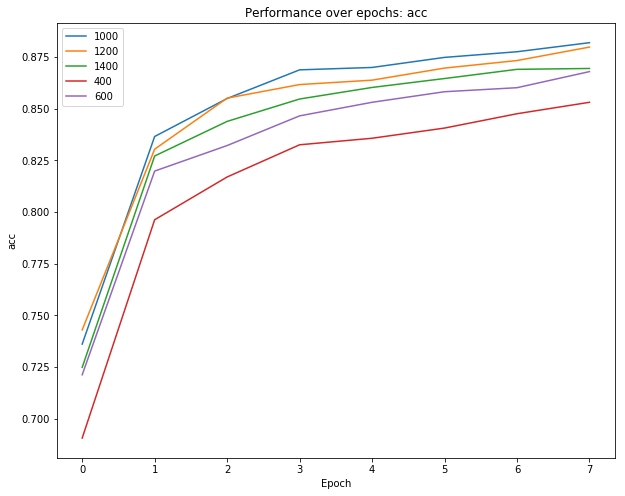

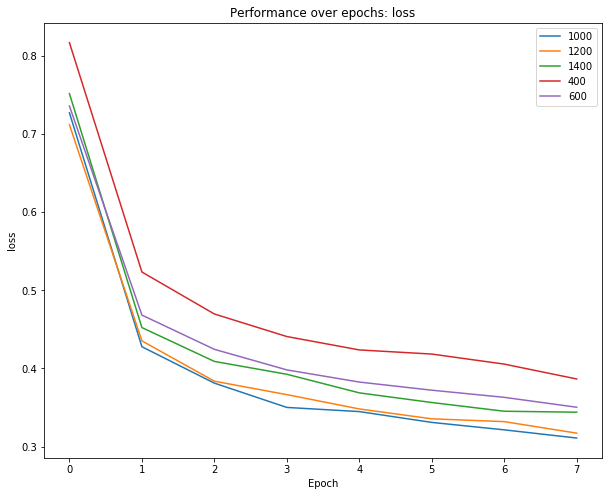

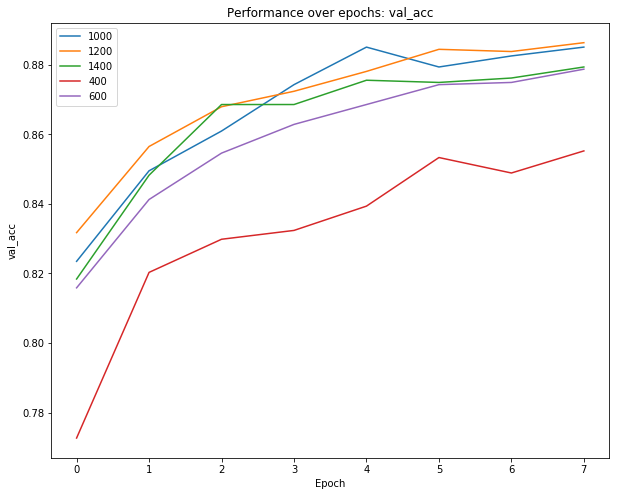

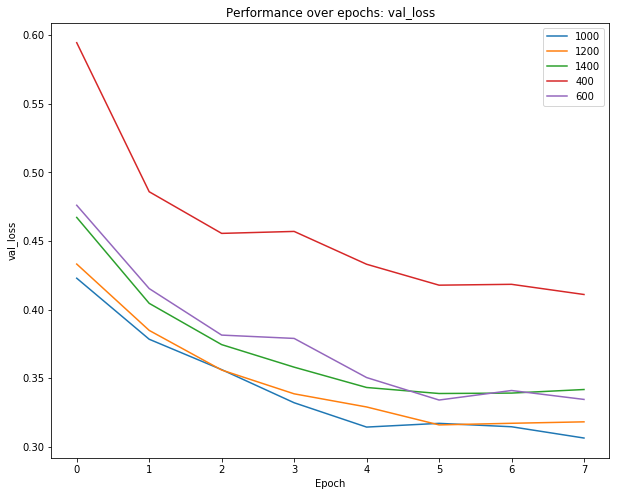

In [11]:
hist_plot = hist_df.drop([800, 1600])

# plot model comparison
c2t.plot_metric('acc', hist_plot)
c2t.plot_metric('loss', hist_plot)
c2t.plot_metric('val_acc', hist_plot)
c2t.plot_metric('val_loss', hist_plot)

In [35]:
import gc

gc.collect()
K.clear_session()